In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/gabriel/anaconda3/envs/modelagem/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Set the default float type to float64


## Reverse Problem for the Burgers' Equation

This notebook solves the reverse Burgers' equation. It is based on the DeepXDE paper tutorial.

This is a convection-diffusion equation that describes non-viscous fluid dynamics and traffic flow:

$$
\frac{∂u}{∂t} + ∇u · u  = v∇²u
$$

Where v is the [diffusion coefficient](https://en.wikipedia.org/wiki/Mass_diffusivity).

Let's solve the 1-dimension version of this problem as formulated by [Nikopoulos <em>et al.</em> (2021)](https://arxiv.org/pdf/2101.05555):

$$
\frac{∂u}{∂t} + u \frac{∂u}{∂x} = v\frac{∂²u}{∂²x} \\
$$

With the following initial and boundary conditions:

$$
u(x, 0) = −sin(πx), \quad x ∈ (−1, 1), \quad
u(±1, t) = 0, \quad t ∈ [0, 5]
$$

In [11]:
# Parameters

x0, xf = -1, 1
t0, tf = 0, 5

Compiling model...
'compile' took 0.000110 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.61e-02, 2.02e-01, 9.39e-01]    [3.61e-02, 2.02e-01, 9.39e-01]    []  
1000      [4.63e-02, 1.35e-03, 2.27e-02]    [4.63e-02, 1.35e-03, 2.27e-02]    []  
2000      [4.34e-02, 5.13e-04, 1.53e-02]    [4.34e-02, 5.13e-04, 1.53e-02]    []  
3000      [4.01e-02, 3.12e-04, 1.44e-02]    [4.01e-02, 3.12e-04, 1.44e-02]    []  
4000      [3.86e-02, 1.14e-04, 1.44e-02]    [3.86e-02, 1.14e-04, 1.44e-02]    []  
5000      [3.83e-02, 1.11e-04, 1.42e-02]    [3.83e-02, 1.11e-04, 1.42e-02]    []  
6000      [3.75e-02, 1.53e-04, 1.40e-02]    [3.75e-02, 1.53e-04, 1.40e-02]    []  
7000      [3.68e-02, 1.60e-04, 1.38e-02]    [3.68e-02, 1.60e-04, 1.38e-02]    []  
8000      [3.65e-02, 1.47e-04, 1.37e-02]    [3.65e-02, 1.47e-04, 1.37e-02]    []  
9000      [3.82e-02, 3.49e-04, 1.23e-02]    [3.82e-02, 3.49e-04, 1.23e-02]    []  
10000     [3.62

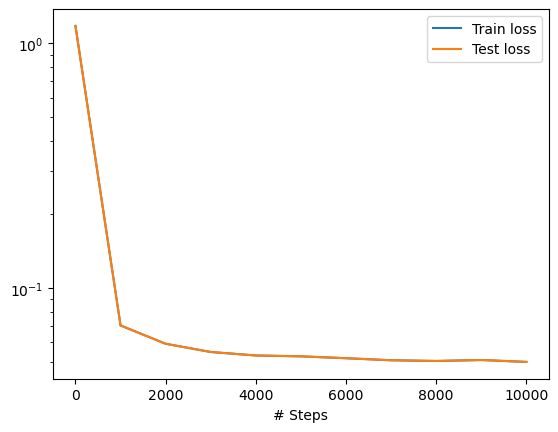

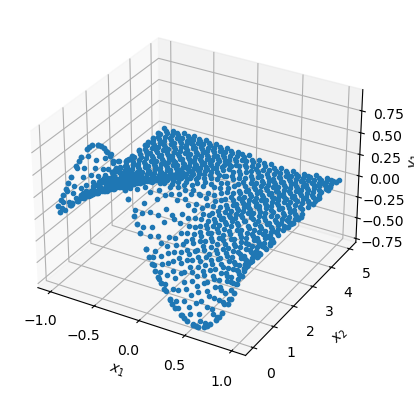

diffusion coefficient v = 0.04804440544133047


In [12]:

# Define the geometry (domain)
space_interval = dde.geometry.Interval(x0, xf)
time_domain = dde.geometry.TimeDomain(t0, tf)
geom = dde.geometry.GeometryXTime(space_interval, time_domain)


# Create external trainable variable and provide an initial guess. 
# For the Burgers' equation that varviable is the diffusion coefficeint
V = dde.Variable(0.5)


# Define the ode/pde
def burgers(x, y):

  du_dx = dde.grad.jacobian(y, x, i=0, j=0)
  du_dt = dde.grad.jacobian(y, x, i=0, j=1)
  d2u_d2x = dde.grad.hessian(y, x, component=0, i=0, j=0)

  return [
      du_dt + y * du_dx - y * V * d2u_d2x
  ]


# Define the initial and boundary conditions
ic = dde.icbc.IC(geom, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary)


# Provide the training data points
data = dde.data.TimePDE(
    geom, 
    burgers, 
    [bc, ic], 
    num_domain=1024, 
    num_boundary=40, 
    num_initial=50)


# Define the network architecture layers sizes, activation function and weights initializer
net = dde.nn.FNN([2] + [5] * 2 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)


# Define the optimizer and learning rate
model.compile("adam", lr=10e-3, external_trainable_variables=[V])


# Train the model for n epochs
losshistory, train_state = model.train(iterations=10000)


# Save and plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Display external variable
print (f"diffusion coefficient v = { V.detach().cpu().numpy()}")


## Bibliography

Nikolopoulos, S., Kalogeris, I., Papadopoulos, V.: Non-intrusive surrogate modeling for parametrized time-dependent pdes using convolutional autoencoders (2021), https://arxiv.org/abs/2101.05555

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.rar.html